# Data Preprocessing

In [1]:
import pandas as pd
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

conn = sqlite3.connect(r'C:\Users\Owner\dev\algobetting\infra\data\db\algobetting.db')

df = pd.read_sql_query("""
                        SELECT DISTINCT
                            f.*,
                            ms.passing_corner_kicks,
                            ms.opp_passing_corner_kicks
                        FROM 
                            team_all_features_365_005 f
                        JOIN
                            fbref_match_summary_v2 ms
                                ON ms.match_url = f.match_url
                                AND ms.team = f.team
                        WHERE 
                            f.team_rolling_summary_minutes IS NOT NULL
                       """, conn)

df

,match_url,match_date,season,division,team,opp_team,is_home,team_rolling_summary_minutes,team_rolling_summary_goals,team_rolling_summary_assists,...,opp_team_rolling_conceded_defense_challenge_tackles_pct,opp_team_rolling_conceded_defense_challenges_lost,opp_team_rolling_conceded_defense_blocked_shots,opp_team_rolling_conceded_defense_blocked_passes,opp_team_rolling_conceded_defense_tackles_interceptions,opp_team_rolling_conceded_defense_clearances,opp_team_rolling_conceded_defense_errors,opp_team_rolling_conceded_keeper_psxg,passing_corner_kicks,opp_passing_corner_kicks
0,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25 00:00:00,2024-2025,Premier League,Tottenham,Brighton,1,989.992406,1.500408,1.112727,...,50.720617,8.796946,3.393454,7.020603,26.403010,27.177737,0.862971,1.299603,2.0,11.0
1,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25 00:00:00,2024-2025,Premier League,Brighton,Tottenham,0,989.335079,1.706913,1.085479,...,57.889854,7.949406,3.378971,9.378588,32.038948,23.558919,0.911136,1.805191,11.0,2.0
2,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25 00:00:00,2024-2025,Premier League,Bournemouth,Leicester City,1,987.964813,1.608621,1.057791,...,53.893970,6.606014,2.506894,6.904780,22.901258,21.697324,0.636969,1.811285,6.0,1.0
3,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25 00:00:00,2024-2025,Premier League,Leicester City,Bournemouth,0,990.000000,0.807435,0.580760,...,49.279905,7.520887,4.153870,6.746572,23.732322,26.770789,1.451179,1.460762,1.0,6.0
4,https://fbref.com/en/matches/36844e73/Newcastl...,2025-05-25 00:00:00,2024-2025,Premier League,Newcastle Utd,Everton,1,989.743387,1.895577,1.347949,...,53.064874,6.895930,2.600829,6.075265,24.063503,26.142993,0.567784,1.251694,12.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39609,https://fbref.com/en/matches/52b3f702/Ascoli-S...,2022-08-20 00:00:00,2022-2023,Serie B,SPAL,Ascoli,0,988.573585,1.033380,0.714620,...,47.569413,8.159022,3.711682,7.091125,27.378805,15.616693,0.151436,1.129866,4.0,10.0
39610,https://fbref.com/en/matches/642065d4/Perugia-...,2022-08-20 00:00:00,2022-2023,Serie B,Perugia,Parma,1,986.716887,1.069842,0.699898,...,45.651851,9.857645,3.224801,7.246526,28.253072,19.824986,0.276461,1.485961,2.0,6.0
39611,https://fbref.com/en/matches/642065d4/Perugia-...,2022-08-20 00:00:00,2022-2023,Serie B,Parma,Perugia,0,988.877537,1.347099,0.722063,...,48.223948,6.436482,3.549705,7.303643,24.939969,19.747866,0.390312,1.204316,6.0,2.0
39612,https://fbref.com/en/matches/c090ef83/Genoa-Be...,2022-08-20 00:00:00,2022-2023,Serie B,Genoa,Benevento,1,988.612932,0.697880,0.529856,...,40.077658,7.792487,3.944566,5.863275,22.638219,21.943802,0.255728,1.197328,8.0,1.0


# EDA

In [12]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simple_poisson_test(data):
   """Simple test for Poisson distribution"""
   data_numeric = pd.to_numeric(data, errors='coerce')
   data_clean = data_numeric.dropna()
   
   mean_val = data_clean.mean()
   var_val = data_clean.var()
   
   print(f"Mean: {mean_val:.2f}")
   print(f"Variance: {var_val:.2f}")
   print(f"Ratio (should be ~1.0): {mean_val/var_val:.2f}")
   
   # Chi-square test
   observed = data_clean.value_counts().sort_index()
   expected = []
   
   for k in observed.index:
       prob = stats.poisson.pmf(k, mean_val)
       expected.append(prob * len(data_clean))
   
   # Force the sums to match exactly
   expected = np.array(expected)
   expected = expected * observed.sum() / expected.sum()
   
   chi2, p_value = stats.chisquare(observed.values, expected)
   
   print(f"\nChi-square test p-value: {p_value:.3f}")
   if p_value > 0.05:
       print("✓ Data likely follows Poisson distribution")
   else:
       print("✗ Data does not follow Poisson distribution")
   
   # Plot comparison
   plt.figure(figsize=(10, 6))
   x = observed.index
   plt.bar(x, observed.values, alpha=0.7, label='Observed', color='blue')
   plt.bar(x, expected, alpha=0.7, label='Expected (Poisson)', color='red')
   plt.xlabel('Corner Kicks')
   plt.ylabel('Frequency')
   plt.title('Observed vs Expected Poisson Distribution')
   plt.legend()
   plt.show()

simple_poisson_test(df["corner_kicks"])

KeyError: 'corner_kicks'

Mean: 5.11
Variance: 8.22
Variance/Mean ratio: 1.61
✓ Data shows overdispersion (variance > mean), negative binomial might be appropriate

Estimated parameters (method of moments):
r (shape): 8.40
p (success probability): 0.622

MLE parameters:
r (shape): 8.23
p (success probability): 0.617

Chi-square test p-value: 0.524
✓ Data consistent with negative binomial distribution


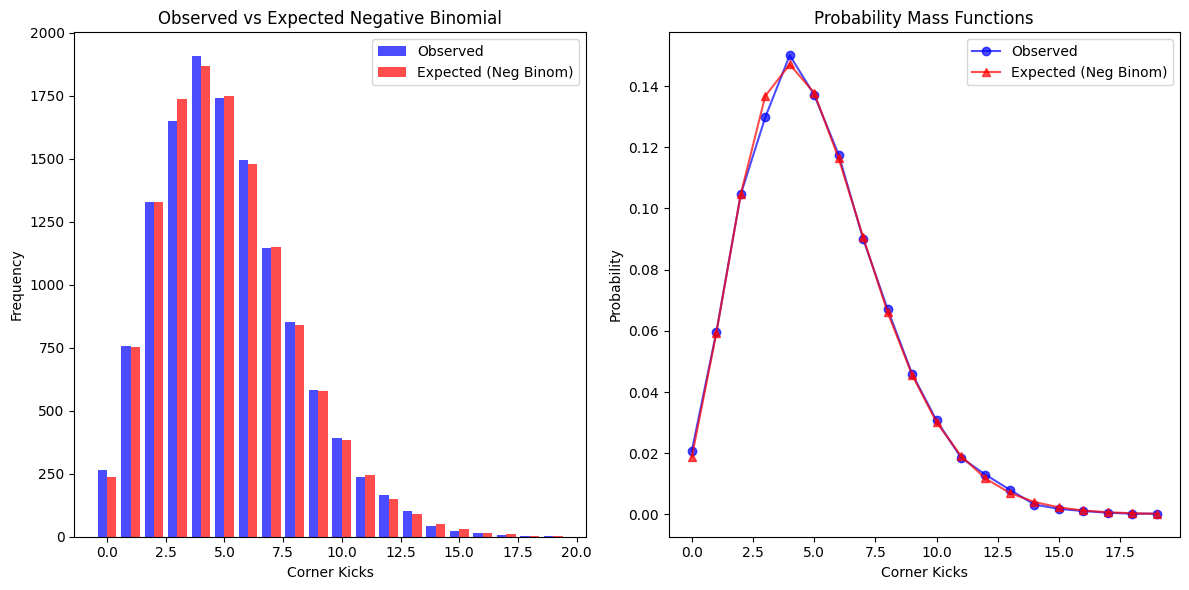

In [13]:
from scipy.optimize import minimize

def negative_binomial_test(data):
    """Test for negative binomial distribution"""
    data_numeric = pd.to_numeric(data, errors='coerce')
    data_clean = data_numeric.dropna()
    
    mean_val = data_clean.mean()
    var_val = data_clean.var()
    
    print(f"Mean: {mean_val:.2f}")
    print(f"Variance: {var_val:.2f}")
    print(f"Variance/Mean ratio: {var_val/mean_val:.2f}")
    
    if var_val/mean_val > 1:
        print("✓ Data shows overdispersion (variance > mean), negative binomial might be appropriate")
    else:
        print("⚠ Data shows underdispersion, Poisson might be better")
    
    # Method of moments estimation for negative binomial parameters
    # For negative binomial: mean = r*p/(1-p), variance = r*p/(1-p)^2
    # This gives us: r = mean^2 / (variance - mean)
    if var_val > mean_val:
        r_est = mean_val**2 / (var_val - mean_val)
        p_est = mean_val / var_val
        
        print(f"\nEstimated parameters (method of moments):")
        print(f"r (shape): {r_est:.2f}")
        print(f"p (success probability): {p_est:.3f}")
        
        # Maximum likelihood estimation (more accurate)
        def neg_log_likelihood(params):
            r, p = params
            if r <= 0 or p <= 0 or p >= 1:
                return np.inf
            return -np.sum(stats.nbinom.logpmf(data_clean, r, p))
        
        # Use method of moments as starting point
        result = minimize(neg_log_likelihood, [r_est, p_est], 
                         bounds=[(0.1, None), (0.001, 0.999)],
                         method='L-BFGS-B')
        
        if result.success:
            r_mle, p_mle = result.x
            print(f"\nMLE parameters:")
            print(f"r (shape): {r_mle:.2f}")
            print(f"p (success probability): {p_mle:.3f}")
            
            # Use MLE parameters for testing
            r_final, p_final = r_mle, p_mle
        else:
            print("MLE failed, using method of moments")
            r_final, p_final = r_est, p_est
        
        # Chi-square goodness of fit test
        observed = data_clean.value_counts().sort_index()
        expected = []
        
        for k in observed.index:
            prob = stats.nbinom.pmf(k, r_final, p_final)
            expected.append(prob * len(data_clean))
        
        expected = np.array(expected)
        expected = expected * observed.sum() / expected.sum()
        
        # Combine small expected frequencies
        min_expected = 5
        obs_combined = []
        exp_combined = []
        current_obs = 0
        current_exp = 0
        
        for i in range(len(observed)):
            current_obs += observed.iloc[i]
            current_exp += expected[i]
            
            if current_exp >= min_expected or i == len(observed) - 1:
                obs_combined.append(current_obs)
                exp_combined.append(current_exp)
                current_obs = 0
                current_exp = 0
        
        if len(obs_combined) > 1:  # Need at least 2 groups for chi-square
            chi2, p_value = stats.chisquare(obs_combined, exp_combined)
            print(f"\nChi-square test p-value: {p_value:.3f}")
            if p_value > 0.05:
                print("✓ Data consistent with negative binomial distribution")
            else:
                print("✗ Data does not fit negative binomial distribution well")
        else:
            print("Not enough data points for chi-square test")
        
        # Plot comparison
        plt.figure(figsize=(12, 6))
        
        # Subplot 1: Bar chart comparison
        plt.subplot(1, 2, 1)
        x = observed.index
        plt.bar(x - 0.2, observed.values, width=0.4, alpha=0.7, label='Observed', color='blue')
        plt.bar(x + 0.2, expected[:len(x)], width=0.4, alpha=0.7, label='Expected (Neg Binom)', color='red')
        plt.xlabel('Corner Kicks')
        plt.ylabel('Frequency')
        plt.title('Observed vs Expected Negative Binomial')
        plt.legend()
        
        # Subplot 2: Probability comparison
        plt.subplot(1, 2, 2)
        x_range = np.arange(0, max(observed.index) + 1)
        obs_probs = observed.values / observed.sum()
        exp_probs = [stats.nbinom.pmf(k, r_final, p_final) for k in x_range]
        
        plt.plot(observed.index, obs_probs, 'bo-', label='Observed', alpha=0.7)
        plt.plot(x_range, exp_probs, 'r^-', label='Expected (Neg Binom)', alpha=0.7)
        plt.xlabel('Corner Kicks')
        plt.ylabel('Probability')
        plt.title('Probability Mass Functions')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        return r_final, p_final
    
    else:
        print("Data doesn't show overdispersion - consider Poisson instead")
        return None, None
    
r, p = negative_binomial_test(df["passing_corner_kicks"])

# Feature Engineering

In [ ]:
"""
# Engineer interaction features
weighted_attack_cols = [col for col in df.columns if col.startswith('team_rolling_')]

# Create new columns by multiplying weighted_attack columns with their opp_weighted_defense counterparts
for col in weighted_attack_cols:
    # Extract the suffix after 'weighted_attack_'
    suffix = col.replace('team_rolling_', '')
    
    # Construct the corresponding opp_weighted_defense column name
    opp_col = f'opp_team_rolling_{suffix}'
    
    # Check if the corresponding opp column exists
    if opp_col in df.columns:
        # Create new column name for the product
        new_col_name = f'product_{suffix}'
        
        # Multiply the columns
        df[new_col_name] = df[col] * df[opp_col]
        print(f"Created: {new_col_name} = {col} * {opp_col}")
    else:
        print(f"Warning: No matching column found for {col} (looked for {opp_col})")

# Alternative approach: Create a dictionary of all products
products = {}
for col in weighted_attack_cols:
    suffix = col.replace('team_rolling_', '')
    opp_col = f'opp_team_rolling_{suffix}'
    
    if opp_col in df.columns:
        products[f'interaction_{suffix}'] = df[col] * df[opp_col]

# Convert dictionary to DataFrame and concatenate with original
if products:
    products_df = pd.DataFrame(products)
    df_with_products = pd.concat([df, products_df], axis=1)

# Display the new columns created
print("\nNew product columns:")
product_cols = [col for col in df.columns if col.startswith('product_')]
print(product_cols)
"""


Created: product_summary_minutes = team_rolling_summary_minutes * opp_team_rolling_summary_minutes
Created: product_summary_goals = team_rolling_summary_goals * opp_team_rolling_summary_goals
Created: product_summary_assists = team_rolling_summary_assists * opp_team_rolling_summary_assists
Created: product_summary_pens_made = team_rolling_summary_pens_made * opp_team_rolling_summary_pens_made
Created: product_summary_pens_att = team_rolling_summary_pens_att * opp_team_rolling_summary_pens_att
Created: product_summary_shots = team_rolling_summary_shots * opp_team_rolling_summary_shots
Created: product_summary_shots_on_target = team_rolling_summary_shots_on_target * opp_team_rolling_summary_shots_on_target
Created: product_summary_cards_yellow = team_rolling_summary_cards_yellow * opp_team_rolling_summary_cards_yellow
Created: product_summary_touches = team_rolling_summary_touches * opp_team_rolling_summary_touches
Created: product_summary_tackles = team_rolling_summary_tackles * opp_tea

C:\Users\Owner\AppData\Local\Temp\ipykernel_10784\1226292419.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df[col] * df[opp_col]
C:\Users\Owner\AppData\Local\Temp\ipykernel_10784\1226292419.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df[col] * df[opp_col]
C:\Users\Owner\AppData\Local\Temp\ipykernel_10784\1226292419.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

In [5]:
df["match_date"] = pd.to_datetime(df["match_date"])
df["year"] = df["match_date"].dt.year
df["month"] = df["match_date"].dt.month
df["day"] = df["match_date"].dt.day
df["dow"] = df["match_date"].dt.day_of_week

df

,match_url,match_date,season,division,team,opp_team,is_home,team_rolling_summary_minutes,team_rolling_summary_goals,team_rolling_summary_assists,...,opp_team_rolling_conceded_defense_tackles_interceptions,opp_team_rolling_conceded_defense_clearances,opp_team_rolling_conceded_defense_errors,opp_team_rolling_conceded_keeper_psxg,passing_corner_kicks,opp_passing_corner_kicks,year,month,day,dow
0,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,2024-2025,Premier League,Tottenham,Brighton,1,989.992406,1.500408,1.112727,...,26.403010,27.177737,0.862971,1.299603,2.0,11.0,2025,5,25,6
1,https://fbref.com/en/matches/e4bb1c35/Tottenha...,2025-05-25,2024-2025,Premier League,Brighton,Tottenham,0,989.335079,1.706913,1.085479,...,32.038948,23.558919,0.911136,1.805191,11.0,2.0,2025,5,25,6
2,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25,2024-2025,Premier League,Bournemouth,Leicester City,1,987.964813,1.608621,1.057791,...,22.901258,21.697324,0.636969,1.811285,6.0,1.0,2025,5,25,6
3,https://fbref.com/en/matches/1ff370e8/Bournemo...,2025-05-25,2024-2025,Premier League,Leicester City,Bournemouth,0,990.000000,0.807435,0.580760,...,23.732322,26.770789,1.451179,1.460762,1.0,6.0,2025,5,25,6
4,https://fbref.com/en/matches/36844e73/Newcastl...,2025-05-25,2024-2025,Premier League,Newcastle Utd,Everton,1,989.743387,1.895577,1.347949,...,24.063503,26.142993,0.567784,1.251694,12.0,3.0,2025,5,25,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12697,https://fbref.com/en/matches/537561a8/Millwall...,2024-08-10,2024-2025,Championship,Millwall,Watford,1,989.736035,0.985593,0.658757,...,26.864903,20.206119,0.193619,1.395242,5.0,4.0,2024,8,10,5
12698,https://fbref.com/en/matches/537561a8/Millwall...,2024-08-10,2024-2025,Championship,Watford,Millwall,0,989.721695,1.235144,0.871746,...,22.887446,20.710798,0.154277,1.197953,4.0,5.0,2024,8,10,5
12699,https://fbref.com/en/matches/8ef33ae3/Preston-...,2024-08-09,2024-2025,Championship,Preston,Sheffield Utd,1,989.786471,1.154977,0.778175,...,23.280416,16.621359,0.243928,2.197294,3.0,6.0,2024,8,9,4
12700,https://fbref.com/en/matches/8ef33ae3/Preston-...,2024-08-09,2024-2025,Championship,Sheffield Utd,Preston,0,988.874304,0.987977,0.566532,...,22.534233,19.879498,0.207106,1.501693,6.0,3.0,2024,8,9,4


# Model Training

In [18]:
df = df.dropna(subset=["passing_corner_kicks"])
X = df.drop(columns=["team", "opp_team", "match_url",  "match_date",  "passing_corner_kicks", "opp_passing_corner_kicks"])
X = pd.get_dummies(X, columns=["season", "division"], drop_first=True)
y = pd.to_numeric(df["passing_corner_kicks"], errors='coerce')

#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.2, random_state=26
#)

# Use matches after a certain date as test
cutoff_date = '2024-01-01'  # adjust as needed
df['match_date'] = pd.to_datetime(df['match_date'])

train_mask = df['match_date'] < cutoff_date
test_mask = df['match_date'] >= cutoff_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(X_train.shape[0])
print(X_test.shape[0])

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Tweedie can handle zeros naturally
params = {
    'objective': 'reg:tweedie',         
    'tweedie_variance_power': 1.6,      # Based on your variance/mean ratio
    'eval_metric': 'tweedie-nloglik@1.6',   
    'eta': 0.05,                    
    'max_depth': 5,                
    'subsample': 0.8,              
    'colsample_bytree': 0.8,       
    'seed': 26,                     
    'verbosity': 0,
    'reg_alpha': 0.5,              
    'reg_lambda': 2.0,             
    'gamma': 0.5,
    'min_child_weight': 5,
}

# Use original targets (zeros allowed)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

num_rounds=1000
model = xgb.train(params, dtrain, num_rounds, 
                 evals=[(dtrain, 'train'), (dtest, 'test')],
                 early_stopping_rounds=10, verbose_eval=False)

# Make predictions
y_pred = model.predict(dtest)

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

# Calculate mean absolute error for count data
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

# Get feature importance
importance = model.get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nFeature Importance:")
for feature, score in importance:
    print(f"{feature}: {score:.2f}")

9961
2741
RMSE: 2.8418
MAE: 2.2005

Feature Importance:
opp_team_rolling_conceded_summary_shots: 55.07
team_rolling_passing_corner_kicks: 37.19
team_rolling_pass_types_corner_kicks: 30.91
is_home: 29.27
opp_team_rolling_conceded_summary_sca: 28.33
team_rolling_possession_touches_att_3rd: 26.49
team_rolling_summary_progressive_passes: 20.05
opp_team_rolling_possession_progressive_passes_received: 19.16
team_rolling_summary_xg_assist: 17.08
opp_team_rolling_possession_touches_att_pen_area: 16.65
team_rolling_summary_progressive_carries: 16.00
opp_team_rolling_possession_touches_att_3rd: 15.37
opp_team_rolling_conceded_misc_crosses: 15.12
team_rolling_passing_through_balls: 14.72
opp_team_rolling_conceded_summary_xg: 14.56
opp_team_rolling_conceded_possession_touches_att_3rd: 14.34
team_rolling_conceded_possession_touches_att_pen_area: 13.84
team_rolling_conceded_summary_npxg: 13.46
opp_team_rolling_conceded_possession_touches_att_pen_area: 13.14
team_rolling_conceded_summary_shots: 13.08